In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
experiment_name = 'CDR'

In [2]:
# %run init.py

print "Setting up variables & DB connection for experiment:\n"
print "*******************\n%s\n*******************"%experiment_name

# point to appropriate DBs, pickle files etc.
pkl_paths = '../pickles/%s/'%experiment_name
path_candidate_dict_pkl = pkl_paths+ 'candidate_dict.pickle' # TODO rename that
path_pubmed_ids_pkl = pkl_paths + 'pubmed_ids.pickle'
path_base_learners = pkl_paths + 'base_learner_predictions' # TODO create dirs


# Shortcuts to connect to database, initialize candidate subclass and return snorkel session
import os
#TODO: set experiment_name and restructure dir
os.environ['SNORKELDB'] = 'postgres:///snorkel'+experiment_name

from snorkel import SnorkelSession
session = SnorkelSession()
from snorkel.models import  Document, Sentence
import matplotlib.pyplot as plt
from snorkel.annotations import save_marginals
from snorkel.models import Candidate, candidate_subclass
ChemicalDisease = candidate_subclass('ChemicalDisease', ['chemical', 'disease'])

print "\nSnorkel session connected to: ",os.environ['SNORKELDB']

Setting up variables & DB connection for experiment:

*******************
CDR
*******************

Snorkel session connected to:  postgres:///snorkelCDR


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
import pickle
from sqlalchemy import  or_, and_,any_
import numpy as np

In [4]:
import re
from io import StringIO

def report_to_df(report):
    report = re.sub(r" +", " ", report).replace("avg / total", "avg/total").replace("\n ", "\n")
    report_df = pd.read_csv(StringIO("Classes" + report), sep=' ', index_col=0)        
    return(report_df)


In [5]:
REGULATOR = ChemicalDisease

## Load & balance dataset

In [6]:
from snorkel.annotations import load_gold_labels,load_marginals

In [7]:

train_cands  = session.query(REGULATOR).filter(REGULATOR.split == 0).order_by(REGULATOR.id).all()
val_cands  = session.query(REGULATOR).filter(REGULATOR.split == 1).order_by(REGULATOR.id).all()
test_cands  = session.query(REGULATOR).filter(REGULATOR.split == 2).order_by(REGULATOR.id).all()
unlab_cands = session.query(REGULATOR).filter(REGULATOR.split == 3).order_by(REGULATOR.id).all()

train_labels  = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, train_cands))
val_labels  = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, val_cands))
test_labels = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, test_cands))
unlab_labels = np.array(map(lambda x: 1 if x.gold_labels[0].value==1 else 0, unlab_cands))

In [24]:
# also copied in ../MLutils.py

from sklearn.utils import shuffle
from imblearn.under_sampling import RandomUnderSampler
import pandas as pd
import numpy as np

def balance_candidates(cands, marginals, rs = 42):
    """Balance and shuffle candidates along with their (prob) labels.
    
    cands: list of candidate objects
    marginals: list of marginal (or not) labels
    rs: int: random_state (used in RandomUnderSampler and sklearn.utils.shuffle) 
    """
    rus = RandomUnderSampler(random_state=rs,return_indices=True)
    marginals_01 = np.round(marginals)

    _,_, indices = rus.fit_sample(pd.DataFrame(marginals), np.round(marginals))

    # shuffle indices
    indices = shuffle(indices, random_state = rs)

    # keep only selected items
    cands_us = [cands[i] for i in indices]
    marginals_us = [marginals[i] for i in indices]
    
    return cands_us, np.array(marginals_us)

In [9]:
train_cands_us, train_labels_us = balance_candidates(train_cands,train_labels)

# LSTM training

In [13]:
from snorkel.learning import GridSearch, RandomSearch, reRNN

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Use the retry module or similar alternatives.


In [11]:
# import matplotlib.pyplot as plt
# plt.hist(train_labels, bins=20)
# plt.title('Training candidates to be applied')
# plt.show()

In [12]:

#    dropout  batch_size  n_epochs     lr  max_sentence_length  rebalance  \
# 2     0.25          32        20  0.001                  128       0.25   
# 8     0.25          32         5  0.001                   64       0.25

In [32]:
# Run in train (D_B)
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'max_sentence_length': 64,
    'dev_ckpt_delay': 0,
}

lstm = reRNN(seed=1701, n_threads=6,)

# lstm.train(train_cands, train_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)
lstm.train(train_cands, train_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)


[reRNN] Training model
[reRNN] n_train=2156  #epochs=20  batch size=64
[reRNN] Epoch 0 (3.71s)	Average loss=0.677157	Dev F1=39.16
[reRNN] Epoch 1 (7.69s)	Average loss=0.548011	Dev F1=48.60
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (12.16s)	Average loss=0.436186	Dev F1=45.49
[reRNN] Epoch 3 (16.56s)	Average loss=0.388340	Dev F1=45.51
[reRNN] Epoch 4 (20.87s)	Average loss=0.342281	Dev F1=44.73
[reRNN] Epoch 5 (24.84s)	Average loss=0.329485	Dev F1=38.25
[reRNN] Epoch 6 (28.92s)	Average loss=0.302020	Dev F1=45.09
[reRNN] Epoch 7 (33.13s)	Average loss=0.292246	Dev F1=43.02
[reRNN] Epoch 8 (37.10s)	Average loss=0.276042	Dev F1=44.27
[reRNN] Epoch 9 (41.06s)	Average loss=0.257948	Dev F1=46.94
[reRNN] Epoch 10 (45.00s)	Average loss=0.253856	Dev F1=41.09
[reRNN] Epoch 11 (48.96s)	Average loss=0.215391	Dev F1=45.09
[reRNN] Epoch 12 (52.95s)	Average loss=0.186918	Dev F1=42.88
[reRNN] Epoch 13 (56.90s)	Average loss=0.164261	Dev F1=47.63
[reRNN] Epoch 14 (60.87s)	Average loss=0.151647	Dev F1=3

In [33]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, val_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.598
Neg. class accuracy: 0.586
Precision            0.419
Recall               0.598
F1                   0.493
----------------------------------------
TP: 183 | FP: 254 | TN: 360 | FN: 123



In [34]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, test_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.626
Neg. class accuracy: 0.568
Precision            0.41
Recall               0.626
F1                   0.495
----------------------------------------
TP: 949 | FP: 1367 | TN: 1798 | FN: 566



In [35]:
lstm.score(test_cands, test_labels)

(0.40975820379965455, 0.6264026402640264, 0.4954320020882276)

#### Train only on unlab (just to put on paper)

In [36]:
# Run in train (D_U)
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   20,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'max_sentence_length': 64,
    'dev_ckpt_delay': 0,
}

lstm = reRNN(seed=1701, n_threads=6,)

# lstm.train(train_cands, train_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)
lstm.train(unlab_cands, unlab_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)


[reRNN] Training model
[reRNN] n_train=4166  #epochs=20  batch size=64
[reRNN] Epoch 0 (7.05s)	Average loss=0.671861	Dev F1=41.60
[reRNN] Epoch 1 (14.37s)	Average loss=0.549744	Dev F1=47.32
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (22.76s)	Average loss=0.463660	Dev F1=43.77
[reRNN] Epoch 3 (31.27s)	Average loss=0.394159	Dev F1=47.54
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (40.21s)	Average loss=0.362295	Dev F1=41.09
[reRNN] Epoch 5 (47.85s)	Average loss=0.316866	Dev F1=46.90
[reRNN] Epoch 6 (55.09s)	Average loss=0.272477	Dev F1=48.91
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 7 (63.48s)	Average loss=0.227113	Dev F1=51.22
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 8 (72.11s)	Average loss=0.185717	Dev F1=50.40
[reRNN] Epoch 9 (79.88s)	Average loss=0.134763	Dev F1=45.70
[reRNN] Epoch 10 (87.37s)	Average loss=0.108493	Dev F1=53.58
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (95.93s)	Average loss=0.088094	Dev F1=52.74
[reRNN] Epoch 12 (103.92s)	Average loss=0.071568	Dev 

In [37]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, val_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.663
Neg. class accuracy: 0.622
Precision            0.467
Recall               0.663
F1                   0.548
----------------------------------------
TP: 203 | FP: 232 | TN: 382 | FN: 103



In [38]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, test_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.716
Neg. class accuracy: 0.577
Precision            0.448
Recall               0.716
F1                   0.551
----------------------------------------
TP: 1085 | FP: 1339 | TN: 1826 | FN: 430



In [39]:
lstm.score(test_cands, test_labels)

(0.4476072607260726, 0.7161716171617162, 0.5509012439705508)

## Run in train+unlab (best case scenario)

In [40]:
full_cands = train_cands+unlab_cands
full_labels = np.append(train_labels,unlab_labels)

In [41]:
# D_B + D_U
train_kwargs = {
    'lr':         0.001,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'max_sentence_length': 64,
    'dev_ckpt_delay': 0,
}

lstm = reRNN(seed=1701, n_threads=6,)

# lstm.train(train_cands, train_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)
lstm.train(full_cands,full_labels, X_dev = val_cands , Y_dev = val_labels, **train_kwargs)


[reRNN] Training model
[reRNN] n_train=6322  #epochs=30  batch size=64
[reRNN] Epoch 0 (10.79s)	Average loss=0.653658	Dev F1=42.61
[reRNN] Epoch 1 (21.86s)	Average loss=0.513376	Dev F1=48.46
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (34.33s)	Average loss=0.433796	Dev F1=46.32
[reRNN] Epoch 3 (45.22s)	Average loss=0.377039	Dev F1=48.72
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (57.79s)	Average loss=0.315843	Dev F1=52.74
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (70.30s)	Average loss=0.254922	Dev F1=53.61
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 6 (82.92s)	Average loss=0.193258	Dev F1=52.50
[reRNN] Epoch 7 (94.26s)	Average loss=0.154356	Dev F1=52.79
[reRNN] Epoch 8 (105.47s)	Average loss=0.110654	Dev F1=54.43
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (118.11s)	Average loss=0.086968	Dev F1=54.82
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (130.57s)	Average loss=0.068642	Dev F1=57.22
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (142.56s)	Average loss=0.081272

In [42]:
tp, fp, tn, fn = lstm.error_analysis(session, val_cands, val_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.781
Neg. class accuracy: 0.583
Precision            0.483
Recall               0.781
F1                   0.597
----------------------------------------
TP: 239 | FP: 256 | TN: 358 | FN: 67



In [43]:
tp, fp, tn, fn = lstm.error_analysis(session, test_cands, test_labels)

Scores (Un-adjusted)
Pos. class accuracy: 0.776
Neg. class accuracy: 0.555
Precision            0.455
Recall               0.776
F1                   0.574
----------------------------------------
TP: 1176 | FP: 1408 | TN: 1757 | FN: 339



In [44]:
lstm.score(test_cands, test_labels)

(0.4551083591331269, 0.7762376237623763, 0.57379848743596)

## Determine sentence length statistics (for LSTM hidden units)

In [16]:
def get_sentence_length(candidate):
    """Get sentence length of a certain candidate"""
    return len(candidate.get_parent().entity_types)

Text(0.5,1,'Sentence length histogram (words)')

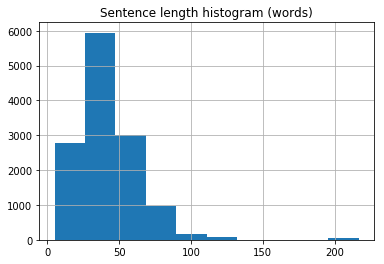

In [17]:
lengths = pd.Series(list(map(lambda x: get_sentence_length(x),train_cands)))
lengths.hist()
plt.title("Sentence length histogram (words)")

# Grid Search

In [18]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   5,
    'dropout':    0.5,
    'rebalance':  0.25,
    'print_freq': 1,
    'batch_size': 32,
    'max_sentence_length': 64,
}

In [20]:
from snorkel.learning import RandomSearch, GridSearch
from snorkel.learning import SparseLogisticRegression

seed = 1234
num_model_search = 10

# search over this parameter grid
param_grid = {}
# param_grid['batch_size'] = [32, 64]
# param_grid['lr']         = [1e-3, 1e-2]
# param_grid['dropout'] = [0.25,0.5]
# param_grid['rebalance']  = [0.0, 0.25]

param_grid['max_sentence_length']  = [32, 64, 128]

param_grid['batch_size'] = [32]
param_grid['lr']         = [1e-3]
param_grid['dropout'] = [0.25]
param_grid['rebalance']  = [0.0, 0.25]
param_grid['n_epochs'] = [5,10,20]


model_hyperparams = {
#     'n_epochs': 20,
    'print_freq': 5,
    'dev_ckpt_delay': 0.5,
    'X_dev': val_cands,
    'Y_dev': val_labels
}

model_class_params = {
    'seed': seed,
    'n_threads':1
}

# Undersampling
searcher = RandomSearch(reRNN, param_grid, train_cands_us, train_marginals_us,
                        n=num_model_search, seed=seed,
                        model_class_params=model_class_params,
                        model_hyperparams=model_hyperparams)

In [ ]:
print "Discriminitive Model Parameter Space (seed={}):".format(seed)
for i, params in enumerate(searcher.search_space()):
    print i, params

disc_model, run_stats = searcher.fit(X_valid=val_cands, Y_valid=val_labels, n_threads=1)
print run_stats

# export results_dict

### Predict on val & unlab 

In [24]:
import pickle

In [25]:
with open(path_candidate_dict_pkl, 'rb') as f:
    cands = pickle.load(f)

In [26]:
# from snorkel.learning import reRNN

# lstm = reRNN(seed=1701, n_threads=None,)

In [27]:
# # lstm.load(model_name='reRNN_14',save_dir="checkpoints/grid_search/")
# disc_model=lstm

In [28]:
from sklearn.metrics import classification_report, f1_score

In [29]:
results_dict = {}

In [30]:

# Validation
val_pred = lstm.predictions(val_cands) # needed for class_report
val_pred_prob = lstm.marginals(val_cands)
val_ids = list(map(lambda x: x.id ,val_cands))
# Test
# test_pred = lstm.predictions(test_cands)
test_pred_prob = lstm.marginals(test_cands)
test_ids = list(map(lambda x: x.id ,test_cands))
# Unlabelled
# unlab_pred = lstm.predictions(unlab_cands)
unlab_pred_prob = lstm.marginals(unlab_cands)
unlab_ids = list(map(lambda x: x.id ,unlab_cands))

# do it with 
val_ground_truth = list(map(lambda x: cands[1][x]['label'], val_ids))
test_ground_truth = list(map(lambda x: cands[2][x]['label'], test_ids))

class_report = report_to_df(classification_report(val_ground_truth, val_pred))

results_dict['biLSTM'] = {'label_val_prob+' :dict(zip(val_ids,val_pred_prob)),
                          'label_test_prob+' :dict(zip(test_ids,test_pred_prob)),
                          'label_unlab_prob+' :dict(zip(unlab_ids,unlab_pred_prob)),
                          "classification_report": class_report,
                          'f1+': f1_score(val_ground_truth, val_pred)
                         }

In [34]:
results_dict.keys()

['biLSTM']

In [33]:
results_dict['biLSTM']['classification_report']

,precision,recall,f1-score,support
Classes,,,,
-1,0.78,0.65,0.71,614
1,0.48,0.63,0.54,306
avg/total,0.68,0.65,0.66,920


In [35]:
with open(path_base_learners+'biLSTM,RuS,lr=0.001,dropout=0.25,34epochs,max_sent_length=64.pkl', 'wb') as f:
    pickle.dump(results_dict, f)

# Below were not run

# Learning curves

** sklearn learning curves **

In [15]:
from sklearn.model_selection import learning_curve
from sklearn.metrics import make_scorer,f1_score,mean_squared_error
from scipy.sparse import vstack

In [ ]:
lstm._build_model

In [17]:
batch_size = 32
epochs=5

In [13]:
# # Wrap as sklearn classifier for learning curves
# from keras.wrappers.scikit_learn import KerasClassifier

# model = KerasClassifier(build_fn=lstm._build_model , batch_size=batch_size, epochs=epochs, verbose=1 ) #callbacks=[metrics])#, epochs=150, batch_size=10, verbose=0)


In [11]:
# train_cands_us, train_labels_us, X_dev = val_cands , Y_dev = val_labels

In [12]:
# train_sizes, train_scores, valid_scores = learning_curve(
#     model,
#     train_cands_us + val_cands , 
#     np.concatenate((train_labels_us, val_labels)), 
# #     shuffle = True,
# #     random_state = 2,
# #     verb
#     #train_sizes=range(1000, X_train.shape[0], 1000), 
#     #     groups = X_all_split,
#     #     scoring = mse_scorer
    
# )

# Gold set LSTM learning curve

** my custom function **

In [16]:
from MLutils import custom_learning_curve, plot_learning_curve

** learning curve (varying number of epochs) **

In [ ]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
    'X_dev': val_cands, 
    'Y_dev': val_labels,
    'verbose': False,
}


In [33]:

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed = 1701), 
    X_increm = unlab_cands, y_increm = unlab_labels, 
    X_val = test_cands, y_val = test_labels, 
    X_init= train_cands, y_init= train_labels,
    X_test = test_cands, y_test = test_labels, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0. 1.]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2060  #epochs=20  batch size=64
[reRNN] Epoch 0 (5.55s)	Average loss=0.579369	Dev F1=42.55
[reRNN] Epoch 1 (13.38s)	Average loss=0.338362	Dev F1=40.52
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (21.45s)	Average loss=0.268916	Dev F1=38.23
[reRNN] Epoch 3 (29.45s)	Average loss=0.227673	Dev F1=38.35
[reRNN] Epoch 4 (37.25s)	Average loss=0.195701	Dev F1=41.87
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (45.20s)	Average loss=0.192741	Dev F1=33.88
[reRNN] Epoch 6 (52.98s)	Average loss=0.193863	Dev F1=37.15
[reRNN] Epoch 7 (60.79s)	Average loss=0.166407	Dev F1=36.37
[reRNN] Epoch 8 (68.62s)	Average loss=0.144665	Dev F1=39.80
[reRNN] Epoch 9 (76.33s)	Average loss=0.134851	Dev F1=37.15
[reRNN] Epoch 10 (84.19s)	Average loss=0.105190	Dev F1=37.96
[reRNN] Epoch 11 (91.97s)	Average loss=0.117071	Dev F1=39.82
[reRNN] Epoch 12 (99.76s)	Average loss=0.127256	Dev F1=36.20
[reRNN] Epoch 13 (107.58s)	Average loss=0.095454	Dev F1=39.29
[reRNN] Epoch 14 (115.3

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.23626664211422435]
F1: [0.45513196480938417]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.23626664211422435, -0.2407921641832225]
F1: [0.45513196480938417, 0.455026455026455]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.23626664211422435, -0.2407921641832225, -0.23098416390394477]
F1: [0.45513196480938417, 0.455026455026455, 0.4579326923076923]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3540  #epochs=20  batch size=64
[reRNN] Epoch 0 (12.17s)	Average loss=0.618063	Dev F1=35.87
[reRNN] Epoch 1 (27.86s)	Average loss=0.377806	Dev F1=45.89
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (43.74s)	Average loss=0.272082	Dev F1=46.49
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (59.59s)	Average loss=0.213872	Dev F1=41.67
[reRNN] Epoch 4 (75.32s)	Average loss=0.182453	Dev F1=42.30
[reRNN] Epoch 5 (90.92s)	Average loss=0.168172	Dev F1=44.60
[reRNN] Epoch 6 (106.58s)	Average loss=0.144912	Dev F1=45.74
[reRNN] Epoch 7 (122.18s)	Average loss=0.125285	Dev F1=45.21
[reRNN] Epoch 8 (138.28s)	Average loss=0.103384	Dev F1=42.01
[reRNN] Epoch 9 (154.18s)	Average loss=0.091427	Dev F1=49.33
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 10 (169.94s)	Average loss=0.094109	Dev F1=50.69
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 11 (185.58s)	Average loss=0.080249	Dev F1=45.22
[reRNN] Epoch 12 (201.35s)	Average loss=0.081420	Dev F1=47.92
[reRNN] Epoch 1

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4530  #epochs=20  batch size=64
[reRNN] Epoch 0 (18.68s)	Average loss=0.697400	Dev F1=22.37
[reRNN] Epoch 1 (40.99s)	Average loss=0.527333	Dev F1=42.32
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (63.15s)	Average loss=0.456738	Dev F1=41.51
[reRNN] Epoch 3 (84.63s)	Average loss=0.373242	Dev F1=43.16
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (106.82s)	Average loss=0.302768	Dev F1=44.19
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (129.91s)	Average loss=0.261948	Dev F1=42.71
[reRNN] Epoch 6 (152.47s)	Average loss=0.247460	Dev F1=39.39
[reRNN] Epoch 7 (174.47s)	Average loss=0.223327	Dev F1=40.37
[reRNN] Epoch 8 (196.16s)	Average loss=0.214107	Dev F1=40.44
[reRNN] Epoch 9 (217.57s)	Average loss=0.201597	Dev F1=41.35
[reRNN] Epoch 10 (239.27s)	Average loss=0.195401	Dev F1=39.33
[reRNN] Epoch 11 (260.77s)	Average loss=0.193476	Dev F1=39.89
[reRNN] Epoch 12 (281.85s)	Average loss=0.181761	Dev F1=40.65
[reRNN] Epoch 13 (303.23s)	Average loss=0.17

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5594  #epochs=20  batch size=64
[reRNN] Epoch 0 (21.76s)	Average loss=0.576185	Dev F1=47.74
[reRNN] Epoch 1 (46.94s)	Average loss=0.370909	Dev F1=49.33
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (72.23s)	Average loss=0.264001	Dev F1=50.30
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 3 (98.28s)	Average loss=0.203046	Dev F1=52.55
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 4 (124.05s)	Average loss=0.146503	Dev F1=51.57
[reRNN] Epoch 5 (149.22s)	Average loss=0.110435	Dev F1=50.94
[reRNN] Epoch 6 (174.68s)	Average loss=0.110290	Dev F1=49.78
[reRNN] Epoch 7 (200.32s)	Average loss=0.080167	Dev F1=49.58
[reRNN] Epoch 8 (225.56s)	Average loss=0.055595	Dev F1=53.70
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 9 (252.74s)	Average loss=0.043690	Dev F1=51.27
[reRNN] Epoch 10 (278.02s)	Average loss=0.048648	Dev F1=48.33
[reRNN] Epoch 11 (303.48s)	Average loss=0.065270	Dev F1=50.50
[reRNN] Epoch 12 (328.45s)	Average loss=0.037749	Dev F1=51.29
[reRNN] Epoch

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6576  #epochs=20  batch size=64
[reRNN] Epoch 0 (25.77s)	Average loss=0.584259	Dev F1=49.74
[reRNN] Epoch 1 (56.79s)	Average loss=0.368082	Dev F1=51.27
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 2 (87.02s)	Average loss=0.264407	Dev F1=47.21
[reRNN] Epoch 3 (116.79s)	Average loss=0.219686	Dev F1=47.55
[reRNN] Epoch 4 (146.98s)	Average loss=0.154301	Dev F1=51.93
[reRNN] Model saved as <reRNN>
[reRNN] Epoch 5 (177.35s)	Average loss=0.111974	Dev F1=49.78
[reRNN] Epoch 6 (207.91s)	Average loss=0.094414	Dev F1=50.70
[reRNN] Epoch 7 (237.52s)	Average loss=0.067909	Dev F1=50.29
[reRNN] Epoch 8 (267.96s)	Average loss=0.073658	Dev F1=49.66
[reRNN] Epoch 9 (298.28s)	Average loss=0.047691	Dev F1=48.29
[reRNN] Epoch 10 (328.55s)	Average loss=0.073711	Dev F1=50.07
[reRNN] Epoch 11 (358.88s)	Average loss=0.040214	Dev F1=46.45
[reRNN] Epoch 12 (389.52s)	Average loss=0.039878	Dev F1=49.85
[reRNN] Epoch 13 (419.31s)	Average loss=0.039076	Dev F1=49.93
[reRNN] Epoc

<module 'matplotlib.pyplot' from '/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

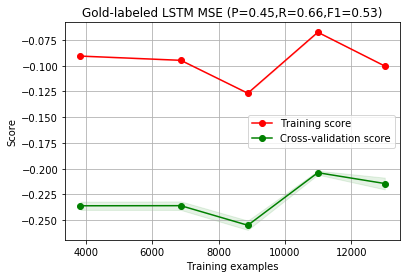

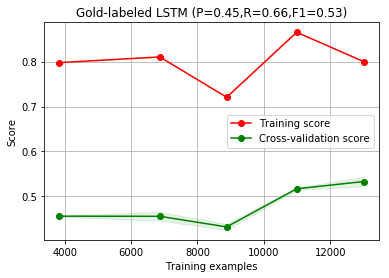

In [34]:

plot_learning_curve(train_mse,valid_mse,train_sizes, 'Gold-labeled LSTM MSE (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))

plot_learning_curve(train_f1,valid_f1,train_sizes, title='Gold-labeled LSTM (P=%.2f,R=%.2f,F1=%.2f)'%(test_prf1))


In [36]:
with open('../'+pkl_paths+"learning_curves/lstm_GoldLabels_var_epochs.pickle",'wb') as f:
    pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)

** with fixed # of epochs **

In [39]:
train_kwargs = {
    'lr':         0.01,
    'dim':        100,
    'n_epochs':   30,
    'dropout':    0.25,
    'rebalance':  True,
    'print_freq': 1,
    'batch_size': 64,
    'dev_ckpt_delay': 0,
#     'X_dev': val_cands, 
#     'Y_dev': val_labels,
    'verbose': False,
}


In [40]:

train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1 = custom_learning_curve(
    reRNN(seed = 1701), 
    X_increm = unlab_cands, y_increm = unlab_labels, 
    X_val = test_cands, y_val = test_labels, 
    X_init= train_cands, y_init= train_labels,
    X_test = test_cands, y_test = test_labels, 
    fit_params = train_kwargs,
#                       splt_sizes=np.array([0.1, 0.5, 1.  ])
                     )


[0. 1.]
<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=2062  #epochs=30  batch size=64
[reRNN] Epoch 0 (5.51s)	Average loss=0.608293
[reRNN] Epoch 1 (10.80s)	Average loss=0.346956
[reRNN] Epoch 2 (16.12s)	Average loss=0.269931
[reRNN] Epoch 3 (21.43s)	Average loss=0.217912
[reRNN] Epoch 4 (26.98s)	Average loss=0.209345
[reRNN] Epoch 5 (32.32s)	Average loss=0.173663
[reRNN] Epoch 6 (37.56s)	Average loss=0.148834
[reRNN] Epoch 7 (42.90s)	Average loss=0.140637
[reRNN] Epoch 8 (48.18s)	Average loss=0.117252
[reRNN] Epoch 9 (53.52s)	Average loss=0.117656
[reRNN] Epoch 10 (58.86s)	Average loss=0.100174
[reRNN] Epoch 11 (64.16s)	Average loss=0.078376
[reRNN] Epoch 12 (69.59s)	Average loss=0.076498
[reRNN] Epoch 13 (74.91s)	Average loss=0.082401
[reRNN] Epoch 14 (80.25s)	Average loss=0.071376
[reRNN] Epoch 15 (85.70s)	Average loss=0.065369
[reRNN] Epoch 16 (91.05s)	Average loss=0.058923
[reRNN] Epoch 17 (96.40s)	Average loss=0.049626
[reRNN] Epoch 18 (101.86s)	Average loss=0.066339
[reRNN] Epoch 19 (107.28s)	

/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 950 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 749 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 751 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 753 has argument past max length for model:	[arg ends at index 164; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.32891687716462226]
F1: [0.43103448275862066]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 935 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 700 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 721 has argument past max length for model:	[arg ends at index 137; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 730 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.32891687716462226, -0.3314536251813434]
F1: [0.43103448275862066, 0.4317280453257791]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 942 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 744 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 754 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 774 has argument past max length for model:	[arg ends at index 160; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

MSE: [-0.32891687716462226, -0.3314536251813434, -0.3198813195826145]
F1: [0.43103448275862066, 0.4317280453257791, 0.4278137890394814]


/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 777 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 782 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 786 has argument past max length for model:	[arg ends at index 117; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNotebooks/snorkel-ml/snorkel/learning/disc_models/rnn/rnn_base.py:40: UserWarning: Candidate 136 has argument past max length for model:	[arg ends at index 131; max len 117]
  warnings.warn('\t'.join([w.format(i), info]))
/home/antonis/ipythonNoteboo

<type 'numpy.ndarray'> <type 'list'>


/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=3590  #epochs=30  batch size=64
[reRNN] Epoch 0 (12.74s)	Average loss=0.601955
[reRNN] Epoch 1 (25.43s)	Average loss=0.387992
[reRNN] Epoch 2 (37.68s)	Average loss=0.280332
[reRNN] Epoch 3 (50.01s)	Average loss=0.217201
[reRNN] Epoch 4 (62.39s)	Average loss=0.180220
[reRNN] Epoch 5 (74.81s)	Average loss=0.150553
[reRNN] Epoch 6 (87.03s)	Average loss=0.131595
[reRNN] Epoch 7 (99.58s)	Average loss=0.120446
[reRNN] Epoch 8 (112.31s)	Average loss=0.087783
[reRNN] Epoch 9 (124.63s)	Average loss=0.085367
[reRNN] Epoch 10 (137.25s)	Average loss=0.067251
[reRNN] Epoch 11 (149.99s)	Average loss=0.062226
[reRNN] Epoch 12 (162.68s)	Average loss=0.062162
[reRNN] Epoch 13 (175.30s)	Average loss=0.053463
[reRNN] Epoch 14 (188.13s)	Average loss=0.032632
[reRNN] Epoch 15 (200.68s)	Average loss=0.027650
[reRNN] Epoch 16 (213.19s)	Average loss=0.038018
[reRNN] Epoch 17 (225.67s)	Average loss=0.037927
[reRNN] Epoch 18 (238.51s)	Average loss=0.035303
[reRNN] Epoch 19

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=4546  #epochs=30  batch size=64
[reRNN] Epoch 0 (27.48s)	Average loss=0.606187
[reRNN] Epoch 1 (55.10s)	Average loss=0.377758
[reRNN] Epoch 2 (82.45s)	Average loss=0.289099
[reRNN] Epoch 3 (110.19s)	Average loss=0.237183
[reRNN] Epoch 4 (141.93s)	Average loss=0.193000
[reRNN] Epoch 5 (170.10s)	Average loss=0.148842
[reRNN] Epoch 6 (197.50s)	Average loss=0.126910
[reRNN] Epoch 7 (224.61s)	Average loss=0.104139
[reRNN] Epoch 8 (251.52s)	Average loss=0.101550
[reRNN] Epoch 9 (278.34s)	Average loss=0.096568
[reRNN] Epoch 10 (305.50s)	Average loss=0.072535
[reRNN] Epoch 11 (335.25s)	Average loss=0.062422
[reRNN] Epoch 12 (365.05s)	Average loss=0.042195
[reRNN] Epoch 13 (390.56s)	Average loss=0.030116
[reRNN] Epoch 14 (417.96s)	Average loss=0.027809
[reRNN] Epoch 15 (447.57s)	Average loss=0.031367
[reRNN] Epoch 16 (476.69s)	Average loss=0.049322
[reRNN] Epoch 17 (505.08s)	Average loss=0.039475
[reRNN] Epoch 18 (532.87s)	Average loss=0.060422
[reRNN] Epo

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=5546  #epochs=30  batch size=64
[reRNN] Epoch 0 (35.20s)	Average loss=0.602684
[reRNN] Epoch 1 (69.71s)	Average loss=0.379638
[reRNN] Epoch 2 (104.06s)	Average loss=0.293787
[reRNN] Epoch 3 (138.29s)	Average loss=0.227558
[reRNN] Epoch 4 (172.71s)	Average loss=0.173088
[reRNN] Epoch 5 (207.15s)	Average loss=0.135504
[reRNN] Epoch 6 (241.72s)	Average loss=0.118027
[reRNN] Epoch 7 (276.19s)	Average loss=0.082613
[reRNN] Epoch 8 (311.14s)	Average loss=0.064406
[reRNN] Epoch 9 (345.28s)	Average loss=0.059423
[reRNN] Epoch 10 (379.71s)	Average loss=0.067577
[reRNN] Epoch 11 (414.02s)	Average loss=0.042721
[reRNN] Epoch 12 (453.08s)	Average loss=0.026311
[reRNN] Epoch 13 (492.24s)	Average loss=0.030640
[reRNN] Epoch 14 (526.46s)	Average loss=0.027157
[reRNN] Epoch 15 (560.72s)	Average loss=0.020598
[reRNN] Epoch 16 (594.98s)	Average loss=0.028824
[reRNN] Epoch 17 (629.28s)	Average loss=0.044524
[reRNN] Epoch 18 (663.13s)	Average loss=0.036952
[reRNN] Ep

/home/antonis/anaconda2/envs/snorkel27clone/lib/python2.7/site-packages/tensorflow/python/ops/gradients_impl.py:100: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


[reRNN] Training model
[reRNN] n_train=6572  #epochs=30  batch size=64
[reRNN] Epoch 0 (44.13s)	Average loss=0.574959
[reRNN] Epoch 1 (88.12s)	Average loss=0.371685
[reRNN] Epoch 2 (132.05s)	Average loss=0.281987
[reRNN] Epoch 3 (175.58s)	Average loss=0.213470
[reRNN] Epoch 4 (219.17s)	Average loss=0.171370
[reRNN] Epoch 5 (263.06s)	Average loss=0.132805
[reRNN] Epoch 6 (306.97s)	Average loss=0.110676
[reRNN] Epoch 7 (350.45s)	Average loss=0.089528
[reRNN] Epoch 8 (394.17s)	Average loss=0.073980
[reRNN] Epoch 9 (437.21s)	Average loss=0.077141
[reRNN] Epoch 10 (480.50s)	Average loss=0.071756
[reRNN] Epoch 11 (523.10s)	Average loss=0.058080
[reRNN] Epoch 12 (567.06s)	Average loss=0.050128
[reRNN] Epoch 13 (610.01s)	Average loss=0.046591
[reRNN] Epoch 14 (662.10s)	Average loss=0.044810
[reRNN] Epoch 15 (711.43s)	Average loss=0.056207
[reRNN] Epoch 16 (753.97s)	Average loss=0.052023
[reRNN] Epoch 17 (797.15s)	Average loss=0.052287
[reRNN] Epoch 18 (840.22s)	Average loss=0.054826
[reRNN] Ep

# ^^^ TODO:: save the log above ^^

In [41]:
# with open('../'+pkl_paths+"learning_curves/lstm_GoldLabels_30_epochs.pickle",'wb') as f:
#     pickle.dump((train_sizes, train_mse, train_f1, valid_mse , valid_f1 , test_prf1), f)